# A Reporting Case-Control Study of AEFIs Following the COVID-19 Vaccine Reported to VAERS

_Chris von Csefalvay_

_04 July 2021_

## Analysis plan

1. Import VAERS data from 2015 onwards, to give a sufficient number of records.
2. We filter out unknown ages and genders.
3. We then bracket age groups: <18, 18-25, 26-35, 36-45, 46-55, 56-65, 66-75, 76-85, 85+
4. We use `pymatch` to create a matched set of controls by:
    * age band
    * gender
5. We drop all events that have fewer than 100 occurrences.
6. We filter for autoimmune aetiologies.
7. Finally, we calculate the reporting odds ratios of all symptoms.

In [37]:
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pymatch.Matcher import Matcher
import sys, re, os, glob
from tqdm.autonotebook import tqdm

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Fixed seed for reproducibility
np.random.seed(4072021)

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"statsmodels version: {statsmodels.__version__}")

pandas version: 1.3.0
numpy version: 1.21.0
statsmodels version: 0.12.2


## Analysis

### Loading VAERS data

Note: for legal reasons, we cannot reproduce the raw VAERS data in Github. However, you can download the VAERS data set
from [HHS](https://vaers.hhs.gov).

In [38]:
%%time

path = "../data/" # use your path
vaccine_files = glob.glob(path + "*VAERSVAX.csv")

vax_frames = []

for filename in tqdm(vaccine_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    vax_frames.append(df)

vax = pd.concat(vax_frames, axis=0, ignore_index=True)[["VAERS_ID", "VAX_TYPE"]]
vax["VAX_TYPE"] = vax["VAX_TYPE"] == "COVID19"
vax.columns = ["VAERS_ID", "IS_COVID_VACCINE"]

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 1.4 s, sys: 357 ms, total: 1.76 s
Wall time: 1.91 s


In [39]:
%%time

recipient_files = glob.glob(path + "*VAERSDATA.csv")

recipient_frames = []

for filename in tqdm(recipient_files):
    df = pd.read_csv(filename, index_col=None, header=0, encoding="latin")
    recipient_frames.append(df)

recipients = pd.concat(recipient_frames, axis=0, ignore_index=True)[["VAERS_ID", "SEX", "CAGE_YR"]]

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 9.16 s, sys: 1.99 s, total: 11.1 s
Wall time: 11.3 s


We age-band recipients by specifying the left margin of each age band.

In [40]:
%%time

age_bands = {0: "<18",
             18: "18-25",
             26: "26-40",
             41: "41-55",
             56: "56-70",
             71: ">70",
             int(recipients.CAGE_YR.max()): "max"}

recipients["AGE"] = pd.cut(recipients.CAGE_YR, bins=list(age_bands.keys()), labels=list(age_bands.values())[:-1])
recipients = recipients.drop("CAGE_YR", axis=1).dropna()

CPU times: user 127 ms, sys: 27 ms, total: 154 ms
Wall time: 152 ms


In [41]:
%%time

symptoms_files = glob.glob(path + "*VAERSSYMPTOMS.csv")

symptoms_frames = []

for filename in tqdm(symptoms_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    symptoms_frames.append(df)


symptoms = pd.melt(pd.concat(symptoms_frames, axis=0, ignore_index=True)[["VAERS_ID", "SYMPTOM1", "SYMPTOM2", "SYMPTOM3", "SYMPTOM4", "SYMPTOM5"]],
               id_vars="VAERS_ID",
               value_vars=(f"SYMPTOM{i}" for i in range(1, 6))).drop("variable", axis=1)

symptoms.columns = ("VAERS_ID", "SYMPTOM")

  0%|          | 0/27 [00:00<?, ?it/s]

CPU times: user 1.88 s, sys: 657 ms, total: 2.54 s
Wall time: 2.55 s


In [42]:
%%time

vaccination_data = vax.merge(recipients, how="inner", on="VAERS_ID")

CPU times: user 205 ms, sys: 117 ms, total: 322 ms
Wall time: 320 ms


In [43]:
print(f"Retrieved {vaccination_data.shape[0]} rows.")
print(f"Breakdown:")
print(f"* COVID-19: {vax[vax.IS_COVID_VACCINE == True][['VAERS_ID']].count().values[0]}")
print(f"* Non-COVID-19: {vax[vax.IS_COVID_VACCINE == False][['VAERS_ID']].count().values[0]}")
print(f" => Gearing: {vax[vax.IS_COVID_VACCINE == False][['VAERS_ID']].count().values[0]/vax[vax.IS_COVID_VACCINE == True][['VAERS_ID']].count().values[0]:.2f}")

Retrieved 1057678 rows.
Breakdown:
* COVID-19: 417186
* Non-COVID-19: 1004170
 => Gearing: 2.41


In [44]:
%%time

case = vax[vax.IS_COVID_VACCINE == True].merge(recipients, how="inner").sample(frac=0.05)
control = vax[vax.IS_COVID_VACCINE == False].merge(recipients, how="inner").sample(frac=0.05)

# Numeric conversion of t/f to make it work with pymatch
case["IS_COVID_VACCINE"] = 1
control["IS_COVID_VACCINE"] = 0

CPU times: user 352 ms, sys: 140 ms, total: 491 ms
Wall time: 490 ms


### Match cases and controls

In [45]:
m = Matcher(case, control, yvar="IS_COVID_VACCINE", exclude=["VAERS_ID"])

Formula:
IS_COVID_VACCINE ~ SEX+AGE
n majority: 34823
n minority: 18061


In [46]:
%%time

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 73.87%
CPU times: user 1min, sys: 8.73 s, total: 1min 9s
Wall time: 22.2 s


In [47]:
%%time

m.predict_scores()

CPU times: user 683 ms, sys: 98.6 ms, total: 782 ms
Wall time: 197 ms


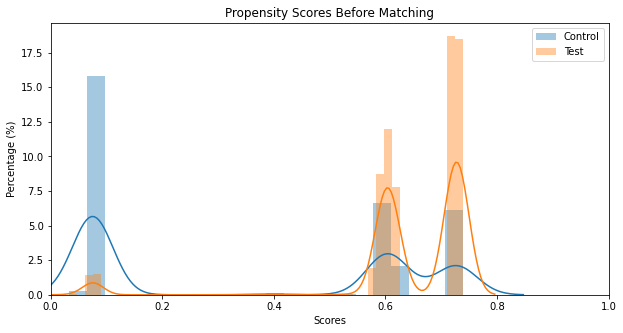

In [48]:
m.plot_scores()

In [49]:
%%time

m.match(method="random", nmatches=1)

CPU times: user 23.7 s, sys: 218 ms, total: 23.9 s
Wall time: 24 s


In [50]:
%%time

m.record_frequency()

CPU times: user 12.8 ms, sys: 3.52 ms, total: 16.3 ms
Wall time: 15.4 ms


,freq,n_records
0,1,24810
1,2,2982
2,3,1146
3,4,328
4,5,87
5,6,20
6,7,5
7,8,1


In [51]:
%%time

m.assign_weight_vector()

CPU times: user 19.3 ms, sys: 3.2 ms, total: 22.5 ms
Wall time: 21.1 ms


In [52]:
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,VAERS_ID,IS_COVID_VACCINE,SEX,AGE,scores,match_id
0,0,1.000000,1404809,1,F,41-55,0.719643,0
21848,25373,0.333333,455293,0,F,41-55,0.719643,0
1,1,1.000000,1002664,1,F,26-40,0.739055,1
26209,33824,1.000000,690877,0,F,26-40,0.739055,1
2,2,1.000000,1267115,1,M,26-40,0.731925,2
31172,43381,0.500000,556102,0,M,26-40,0.731925,2


In [66]:
matched_up_symptoms = pd.DataFrame(m.matched_data.VAERS_ID).merge(vax, how="inner").merge(symptoms.dropna(), how="inner").drop_duplicates()

In [83]:
p_normals = r".*negative$|.*\snormal$|.*(scopy|graphy|gram|metry|opsy)$|.*(count|percentage|level|test|assay|culture|X-ray|imaging|gradient|band(s)?|index|surface area|gas|scale|antibod(y|ies)|urine absent|Carotid pulse|partial pressure|time|P(C)?O2)$|Oxygen saturation$|End-tidal.*"
p_tests = r".*(ase|ose|ine|enzyme|in|ine|ines|ium|ol|ole|ate|lytes|ogen|gases|oids|ide|one|an|copper|iron)$|.*(level therapeutic)$|.*(globulin)\s.{1,2}$|Barium (swallow|enema)"
p_procedures = r".*(plasty|insertion|tomy|ery|puncture|therapy|treatment|tripsy|operation|repair|procedure|bypass|insertion|removal|graft|closure|implant|lavage|support|transplant|match|bridement|application|ablation)$|Incisional drainage$|.* stimulation$|Immunisation$"
p_normal_procedures = r"(Biopsy|pH|.* examination|X-ray|.* pulse|Blood|Electro(.*)gram|.* test(s)?|Echo(.*)gram|.*(scopy)|Cardiac (imaging|monitoring|ventriculogram)|Chromosomal|Carbohydrate antigen|Cell marker|.* examination|Computerised tomogram|Culture|.* evoked potential(s)?|Cytology|Doppler)(?!.*(abnormal|increased|decreased|depression|elevation|present|absent))"
p_managements = r"(Catheter|Device\).*|.* care$|.* user$|Cardiac pacemaker .*"
p_other_irrelevants = r"Blood group.*|Blood don(or|ation)$|Drug (abuse(r)?|dependence|screen).*|Elderly|Non-tobacco user|No adverse event"
p_covid_related = r".*COVID-19(prophylaxis|immunisation|screening)|Asymptomatic COVID-19"

p = re.compile("|".join([p_normals, p_tests, p_procedures, p_normal_procedures, p_other_irrelevants, p_covid_related]))


In [84]:
xt_by_symptom = pd.DataFrame(pd.crosstab(index=matched_up_symptoms.IS_COVID_VACCINE, columns=matched_up_symptoms.SYMPTOM))
columns_to_keep = [x for x in list(xt_by_symptom.columns) if not p.match(x)]
xt_by_symptom = xt_by_symptom[columns_to_keep]

In [129]:
odds_ratios_by_symptom = pd.DataFrame(columns=xt_by_symptom.columns,
                                      index=xt_by_symptom.index)

symptom_sums = xt_by_symptom.sum(axis=0)
vax_sums = xt_by_symptom.sum(axis=1)[True]
xt_by_symptom_total = xt_by_symptom.sum().sum()

symptom_iterator = tqdm(xt_by_symptom.columns)

res = pd.DataFrame(index = xt_by_symptom.columns, columns = ("ROR", "SE", "95CI_upper", "95CI_lower"))

for symptom in symptom_iterator:
    symptom_iterator.set_description(f"Processing: {symptom}")
    a = xt_by_symptom.loc[True, symptom]
    b = vax_sums - a
    c = xt_by_symptom.loc[False, symptom]
    d = xt_by_symptom_total - (a + c + d)

    OR = (a * d) / (c * b) if c * b > 0 else np.nan
    SE = np.sqrt((1/a if a > 0 else 0) + (1/b if b > 0 else 0) + (1/c if c > 0 else 0) + (1/d if d > 0 else 0))

    res.loc[symptom, "ROR"] = OR
    res.loc[symptom, "SE"] = SE
    res.loc[symptom, "95CI_upper"] = np.e ** (np.log(OR) + 1.96 * SE)
    res.loc[symptom, "95CI_lower"] = np.e ** (np.log(OR) - 1.96 * SE)

  0%|          | 0/2847 [00:00<?, ?it/s]

In [123]:
autoimmune_conditions = (
    "Alveolar proteinosis",
    "Ankylosing spondylitis",
    "Antisynthetase syndrome",
    "Autoimmune colitis",
    "Autoimmune disorder",
    "Autoimmune hyperlipidaemia",
    "Autoimmune inner ear disease",
    "Autoimmune lymphoproliferative syndrome",
    "Autoimmune myocarditis",
    "Autoimmune nephritis",
    "Autoimmune pericarditis",
    "Autoimmune retinopathy",
    "Autoimmune uveitis",
    "Axial spondyloarthritis",
    "Birdshot chorioretinopathy",
    "Chronic autoimmune glomerulonephritis",
    "Chronic gastritis",
    "Chronic recurrent multifocal osteomyelitis",
    "Coeliac disease",
    "Collagen disorder",
    "Collagen-vascular disease",
    "Cryofibrinogenaemia",
    "Cryoglobulinaemia",
    "Dermatomyositis",
    "Dressler's syndrome",
    "Glomerulonephritis rapidly progressive",
    "Goodpasture's syndrome",
    "Immunoglobulin G4 related disease",
    "Juvenile spondyloarthritis",
    "Keratoderma blenorrhagica",
    "Mixed connective tissue disease",
    "Myocarditis post infection",
    "Ocular pemphigoid",
    "Overlap syndrome",
    "Polychondritis",
    "Postpericardiotomy syndrome",
    "Pulmonary renal syndrome",
    "Reiter's syndrome",
    "Satoyoshi syndrome",
    "Sjogren's syndrome",
    "Sympathetic ophthalmia",
    "Testicular autoimmunity",
    "Undifferentiated connective tissue disease",
    "Antiphospholipid syndrome",
    "Autoimmune anaemia",
    "Autoimmune aplastic anaemia",
    "Autoimmune haemolytic anaemia",
    "Autoimmune neutropenia",
    "Autoimmune pancytopenia",
    "Cold type haemolytic anaemia",
    "Coombs positive haemolytic anaemia",
    "Evans syndrome",
    "Immune thrombocytopenic purpura",
    "Pernicious anaemia",
    "Warm type haemolytic anaemia",
    "Addison's disease",
    "Atrophic thyroiditis",
    "Autoimmune endocrine disorder",
    "Autoimmune hypothyroidism",
    "Autoimmune pancreatitis",
    "Autoimmune thyroid disorder",
    "Autoimmune thyroiditis",
    "Basedow's disease",
    "Diabetic mastopathy",
    "Endocrine ophthalmopathy",
    "Hashimoto's encephalopathy",
    "Hashitoxicosis",
    "Insulin autoimmune syndrome",
    "Ketosis-prone diabetes mellitus",
    "Latent autoimmune diabetes in adults",
    "Lymphocytic hypophysitis",
    "Marine Lenhart syndrome",
    "Polyglandular autoimmune syndrome type I",
    "Polyglandular autoimmune syndrome type II",
    "Polyglandular autoimmune syndrome type III",
    "Silent thyroiditis",
    "Type 1 diabetes mellitus",
    "Autoimmune hepatitis",
    "Biliary cirrhosis primary",
    "Cholangitis sclerosing",
    "Acute cutaneous lupus erythematosus",
    "Butterfly rash",
    "Central nervous system lupus",
    "Chronic cutaneous lupus erythematosus",
    "Cutaneous lupus erythematosus",
    "Lupoid hepatic cirrhosis",
    "Lupus cystitis",
    "Lupus encephalitis",
    "Lupus endocarditis",
    "Lupus enteritis",
    "Lupus hepatitis",
    "Lupus myocarditis",
    "Lupus myositis",
    "Lupus nephritis",
    "Lupus pancreatitis",
    "Lupus pleurisy",
    "Lupus pneumonitis",
    "Lupus vasculitis",
    "Lupus-like syndrome",
    "Neonatal lupus erythematosus",
    "Neuropsychiatric lupus",
    "Pericarditis lupus",
    "Peritonitis lupus",
    "Shrinking lung syndrome",
    "SLE arthritis",
    "Subacute cutaneous lupus erythematosus",
    "Systemic lupus erythematosus",
    "Systemic lupus erythematosus rash",
    "Immune-mediated necrotising myopathy",
    "Inclusion body myositis",
    "Juvenile polymyositis",
    "Morvan syndrome",
    "Myasthenia gravis",
    "Myasthenia gravis crisis",
    "Myasthenia gravis neonatal",
    "Myasthenic syndrome",
    "Neuromyotonia",
    "Ocular myasthenia",
    "Polymyalgia rheumatica",
    "Polymyositis",
    "Acute disseminated encephalomyelitis",
    "Acute haemorrhagic leukoencephalitis",
    "Acute motor axonal neuropathy",
    "Acute motor-sensory axonal neuropathy",
    "Anti-myelin-associated glycoprotein associated polyneuropathy",
    "Autoimmune demyelinating disease",
    "Autoimmune encephalopathy",
    "Autoimmune neuropathy",
    "Bickerstaff's encephalitis",
    "Chronic inflammatory demyelinating polyradiculoneuropathy",
    "Chronic lymphocytic inflammation with pontine perivascular enhancement responsive to steroids",
    "Concentric sclerosis",
    "Demyelinating polyneuropathy",
    "Encephalitis allergic",
    "Encephalitis autoimmune",
    "Guillain-Barre syndrome",
    "Leukoencephalomyelitis",
    "Limbic encephalitis",
    "Multiple sclerosis",
    "Myelitis transverse",
    "Neuralgic amyotrophy",
    "Neuromyelitis optica spectrum disorder",
    "Optic neuritis",
    "Paediatric autoimmune neuropsychiatric disorders associated with streptococcal infection",
    "POEMS syndrome",
    "Radiologically isolated syndrome",
    "Rasmussen encephalitis",
    "Secondary cerebellar degeneration",
    "Stiff leg syndrome",
    "Stiff person syndrome",
    "Susac's syndrome",
    "Toxic oil syndrome",
    "Autoimmune arthritis",
    "Caplan's syndrome",
    "Cogan's syndrome",
    "Felty's syndrome",
    "Juvenile idiopathic arthritis",
    "Laryngeal rheumatoid arthritis",
    "Palindromic rheumatism",
    "Rheumatoid arthritis",
    "Rheumatoid lung",
    "Rheumatoid neutrophilic dermatosis",
    "Rheumatoid nodule",
    "Rheumatoid scleritis",
    "Rheumatoid vasculitis",
    "CREST syndrome",
    "Digital pitting scar",
    "Morphoea",
    "Reynold's syndrome",
    "Sclerodactylia",
    "Scleroderma",
    "Scleroderma associated digital ulcer",
    "Scleroderma renal crisis",
    "Scleroderma-like reaction",
    "Systemic scleroderma",
    "Systemic sclerosis pulmonary",
    "Alopecia areata",
    "Autoimmune dermatitis",
    "Benign familial pemphigus",
    "Dermatitis herpetiformis",
    "Eosinophilic fasciitis",
    "Granulomatous dermatitis",
    "Herpes gestationis",
    "Interstitial granulomatous dermatitis",
    "Linear IgA disease",
    "Nephrogenic systemic fibrosis",
    "Palisaded neutrophilic granulomatous dermatitis",
    "Paraneoplastic dermatomyositis",
    "Paraneoplastic pemphigus",
    "Pemphigoid",
    "Pemphigus",
    "Pityriasis lichenoides et varioliformis acuta",
    "Progressive facial hemiatrophy",
    "Pyoderma gangrenosum",
    "Vitiligo",
    "Autoinflammatory disease",
    "Blau syndrome",
    "CANDLE syndrome",
    "Chronic infantile neurological cutaneous and articular syndrome",
    "Cryopyrin associated periodic syndrome",
    "Deficiency of the interleukin-1 receptor antagonist",
    "Deficiency of the interleukin-36 receptor antagonist",
    "Familial cold autoinflammatory syndrome",
    "Hyper IgD syndrome",
    "Majeed's syndrome",
    "Mevalonate kinase deficiency",
    "Mevalonic aciduria",
    "Muckle-Wells syndrome",
    "Pyogenic sterile arthritis pyoderma gangrenosum and acne syndrome",
    "Still's disease"
)

In [130]:
res.loc[[x for x in res.index if x in autoimmune_conditions],:].dropna()

,ROR,SE,95CI_upper,95CI_lower
SYMPTOM,,,,
Acute disseminated encephalomyelitis,0.0,0.447248,0.0,0.0
Alopecia areata,1.185035,1.224762,13.069813,0.107447
Ankylosing spondylitis,1.007458,1.414224,16.1079,0.063011
Autoimmune disorder,0.544566,0.507549,1.472602,0.20138
Autoimmune hepatitis,0.998311,1.414224,15.961648,0.062439
Autoimmune thyroiditis,0.200643,1.154718,1.929037,0.020869
Bickerstaff's encephalitis,0.0,1.000015,0.0,0.0
Chronic inflammatory demyelinating polyradiculoneuropathy,0.0,0.500039,0.0,0.0
Collagen disorder,0.0,1.000015,0.0,0.0
